In [1]:
DATA_PATH="./data"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
FORCE_REDOWNLOAD = False

In [5]:
urls = [
    "https://spoiler-datasets.s3.eu-central-1.amazonaws.com/goodreads_balanced-train.json.gz",
    "https://spoiler-datasets.s3.eu-central-1.amazonaws.com/goodreads_balanced-val.json.gz",
    "https://spoiler-datasets.s3.eu-central-1.amazonaws.com/goodreads_balanced-test.json.gz"
]
import urllib.request
import os
import json
import gzip

goodreads_train = []
goodreads_val = []
goodreads_test = []

for goodreads_list, url in zip(
        [goodreads_train, goodreads_val, goodreads_test], urls):
    file = f"{DATA_PATH}/goodreads/{url.rsplit('/', 1)[-1]}"
    if not os.path.exists(file) or FORCE_REDOWNLOAD:
        urllib.request.urlretrieve(url, file)

    with gzip.open(file, "rb") as f:
        for line in tqdm(f):
            goodreads_list.append(json.loads(line))

143402it [00:07, 17998.74it/s]
17926it [00:00, 34192.36it/s]
17926it [00:01, 12071.94it/s]


In [6]:
goodreads_train[0]

{'user_id': '1ceef4796fb36190e72714895806835b',
 'timestamp': 1445212800000,
 'review_sentences': [[0,
   'When I read through this book, I absolutely loved it!'],
  [0,
   'I was completely swept up in the emotions and related to almost everything Willowdean was going through.'],
  [0,
   'If I had written my review immediately, I would have given it 5/5 stars.'],
  [0, 'But I waited.'],
  [0, 'And I tried describing the book to my Mom and Sister.'],
  [0,
   "I started really thinking about what I had read and realized that I didn't really like it all that much."],
  [0, 'Willowdean was a complete and utter bitch!'],
  [1,
   'She jerked around two really great guys and still got her happy ending.'],
  [1, 'She treated her Mom like shit and her mom just took it.'],
  [1,
   'Admittedly, her Mom was negative towards her too, but this dysfunction was a two way street.'],
  [0, 'All of that just ruined the book for me.']],
 'rating': 3,
 'has_spoiler': True,
 'book_id': 18304322,
 'revi

In [7]:
len(goodreads_train), len(goodreads_val), len(goodreads_test)

(143402, 17926, 17926)

# Data analysis

UWAGA! BERT przyjmuje tylko 512 tokenów. Może się zdarzyć, że wśród pierwszych 512 tokenów danej recenzji nie ma spoilera, więc BERT ma w tej sytuacji problem. Celem poniższej krótkiej analizy jest sprawdzenie, jak duży jest to problem. Z drugiej strony, może BERT będzie w stanie ogarnąć to jakoś inaczej? Na podstawie stylu pisma itp.?

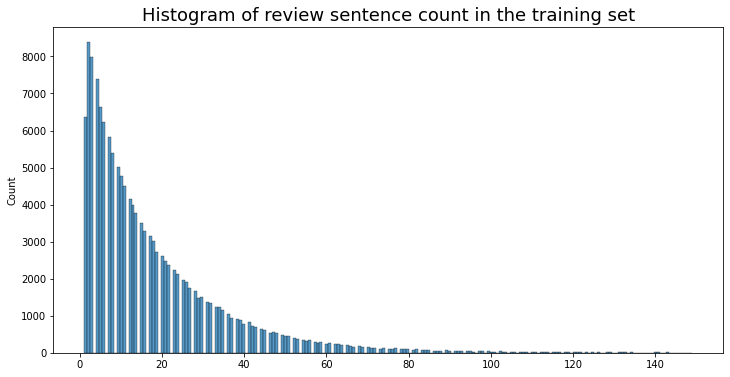

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot([len(x["review_sentences"]) for x in goodreads_train])
plt.title("Histogram of review sentence count in the training set", fontsize=18)
plt.show()

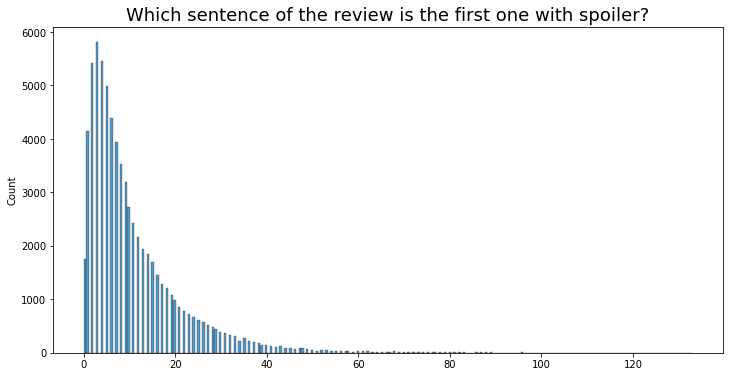

In [9]:
plt.figure(figsize=(12, 6))
first_spoiler_sentence_indices = [next(
    i for i, y in enumerate(x["review_sentences"]) if y[0] == 1) 
              for x in goodreads_train if x["has_spoiler"]]
sns.histplot(first_spoiler_sentence_indices)
plt.title("Which sentence of the review is the first one with spoiler?", fontsize=18)
plt.show()

In [10]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
def preprocess_function_dont_truncate(data):
    return tokenizer(data["text"], truncation=False)

tokenized_untruncated_train = Dataset.from_list([
    {'text': ''.join(y[1] for y in x['review_sentences']), 'label': x['has_spoiler']}
    for x in goodreads_train
    ]).map(preprocess_function_dont_truncate, batched=True)

  0%|          | 0/144 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1024 > 512). Running this sequence through the model will result in indexing errors


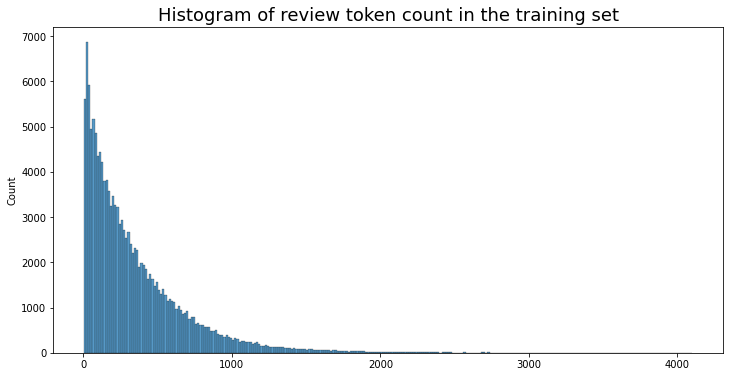

In [12]:
plt.figure(figsize=(12,6))
sns.histplot([len(x["input_ids"]) for x in tokenized_untruncated_train])
plt.title("Histogram of review token count in the training set", fontsize=18)
plt.show()

In [13]:
np.mean([len(tokenized_untruncated_train[i]["input_ids"]) / len(goodreads_train[i]["review_sentences"]) for i in range(len(goodreads_train))])

19.675613446346635

On average, there are 20 tokens per sentence. BERT takes 512 tokens as an input. Therefore, it takes on average up to 25 sentences as an input.

In [14]:
np.mean(np.array(first_spoiler_sentence_indices) < 25)

0.8998061393843879

Therefore, approx. 90% of reviews annotated as having spoilers have spoiler sentence among those considered by BERT.

# BERT Model

See https://huggingface.co/docs/transformers/tasks/sequence_classification

In [15]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [18]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, classifier_dropout=0.1)

2022-11-24 22:13:41.542176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 22:13:42.092124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-24 22:13:43.337285: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: [

In [19]:
def create_tf_dataset(goodreads_list):
    tokenized_goodreads = Dataset.from_list([
        {'text': ''.join(y[1] for y in x['review_sentences']), 'label': x['has_spoiler']}
        for x in goodreads_list
        ]).map(preprocess_function, batched=True)
    return model.prepare_tf_dataset(
        tokenized_goodreads, shuffle=True, batch_size=32, collate_fn=data_collator
    )

In [20]:
tf_goodreads_train = create_tf_dataset(goodreads_train)
tf_goodreads_val = create_tf_dataset(goodreads_val)
tf_goodreads_test = create_tf_dataset(goodreads_test)

  0%|          | 0/144 [00:00<?, ?ba/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/18 [00:00<?, ?ba/s]

In [21]:
from transformers import create_optimizer

batch_size = 32

num_epochs = 3

batches_per_epoch = len(goodreads_train) // batch_size

total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, 
    num_train_steps=total_train_steps)

In [22]:
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [23]:
model.compile(optimizer=optimizer,
             metrics=['accuracy', BalancedSparseCategoricalAccuracy()])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"./checkpoints/best_val_{model_name}",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [25]:
model.fit(x=tf_goodreads_train, validation_data=tf_goodreads_val, epochs=3, callbacks=[model_checkpoint_callback])

Epoch 1/3
4481/4481 [==============================] - 2113s 468ms/step - loss: 0.4276 - accuracy: 0.7989 - balanced_sparse_categorical_accuracy: 0.7987 - val_loss: 0.3989 - val_accuracy: 0.8125 - val_balanced_sparse_categorical_accuracy: 0.8127
Epoch 2/3
4481/4481 [==============================] - 2093s 467ms/step - loss: 0.3350 - accuracy: 0.8504 - balanced_sparse_categorical_accuracy: 0.8505 - val_loss: 0.4118 - val_accuracy: 0.8198 - val_balanced_sparse_categorical_accuracy: 0.8191
Epoch 3/3
4481/4481 [==============================] - 2088s 466ms/step - loss: 0.2447 - accuracy: 0.8963 - balanced_sparse_categorical_accuracy: 0.8963 - val_loss: 0.4739 - val_accuracy: 0.8138 - val_balanced_sparse_categorical_accuracy: 0.8140


In [26]:
model.load_weights(f"./checkpoints/best_val_{model_name}")

In [27]:
model.evaluate(tf_goodreads_test)

560/560 [==============================] - 88s 158ms/step - loss: 0.4052 - accuracy: 0.8194 - balanced_sparse_categorical_accuracy: 0.8199


[0.40519654750823975, 0.8194196224212646, 0.8198690414428711]

In [28]:
from tqdm import tqdm

In [29]:
auc = tf.keras.metrics.AUC()
acc = tf.keras.metrics.Accuracy()
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

fp = tf.keras.metrics.FalsePositives()
fn = tf.keras.metrics.FalseNegatives()
tp = tf.keras.metrics.TruePositives()
tn = tf.keras.metrics.TrueNegatives()

for batch_data, batch_labels in tqdm(tf_goodreads_test):
    preds = tf.nn.softmax(model(batch_data)[0])[:,1]
    auc.update_state(batch_labels, preds)
    acc.update_state(batch_labels, preds>=0.5)
    recall.update_state(batch_labels, preds>=0.5)
    precision.update_state(batch_labels, preds>=0.5)
    
    fp.update_state(batch_labels, preds >= 0.5)
    fn.update_state(batch_labels, preds >= 0.5)
    tp.update_state(batch_labels, preds >= 0.5)
    tn.update_state(batch_labels, preds >= 0.5)

100%|██████████| 560/560 [02:21<00:00,  3.95it/s]


In [30]:
acc.result().numpy()

0.81936383

# ROC AUC

In [31]:
auc.result().numpy(), recall.result().numpy(), precision.result().numpy()

(0.90466356, 0.81430644, 0.8226606)

In [32]:
fp.result().numpy(), tp.result().numpy()

(1573.0, 7297.0)

In [33]:
fn.result().numpy(), tn.result().numpy()

(1664.0, 7386.0)

# Goodreads whole

In [34]:
from itertools import chain

In [35]:
exclude_reviews = set(x["review_id"] for x in chain(goodreads_train, goodreads_test))
len(exclude_reviews)

161328

In [36]:
next(iter(exclude_reviews))

'68af3df931cfe31217055725e84251e0'

In [37]:
whole_goodreads_test = []
file = f"{DATA_PATH}/goodreads/goodreads_reviews_spoiler.json"

with open(file, "r") as f:
    for line in tqdm(f):
        as_json = json.loads(line)
        if as_json["review_id"] not in exclude_reviews:
            whole_goodreads_test.append(as_json)

1378033it [00:38, 36241.07it/s]


In [38]:
len(whole_goodreads_test)

1216705

In [39]:
len([x for x in whole_goodreads_test if x['has_spoiler']])

8963

In [40]:
8963/1216705

0.007366617216169901

In [41]:
len([x for x in whole_goodreads_test if not x['has_spoiler']])

1207742

In [42]:
whole_goodreads_test[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'timestamp': '2017-03-22',
 'review_sentences': [[0, 'Recommended by Don Katz.'],
  [0, 'Avail for free in December: http://www.audible.com/mt/ellison2?so...']],
 'rating': 3,
 'has_spoiler': False,
 'book_id': '16981',
 'review_id': 'a5d2c3628987712d0e05c4f90798eb67'}

In [43]:
tf_whole_goodreads_test = create_tf_dataset(whole_goodreads_test)

  0%|          | 0/1217 [00:00<?, ?ba/s]

In [44]:
del whole_goodreads_test

In [ ]:
auc = tf.keras.metrics.AUC()
acc = tf.keras.metrics.Accuracy()

fp = tf.keras.metrics.FalsePositives()
fn = tf.keras.metrics.FalseNegatives()
tp = tf.keras.metrics.TruePositives()
tn = tf.keras.metrics.TrueNegatives()

for batch_data, batch_labels in tqdm(tf_whole_goodreads_test):
    preds = tf.nn.softmax(model(batch_data)[0])[:,1]
    auc.update_state(batch_labels, preds)
    acc.update_state(batch_labels, preds>=0.5)
    
    fp.update_state(batch_labels, preds >= 0.5)
    fn.update_state(batch_labels, preds >= 0.5)
    tp.update_state(batch_labels, preds >= 0.5)
    tn.update_state(batch_labels, preds >= 0.5)

  1%|          | 199/38022 [00:32<1:37:39,  6.45it/s]

AUC, ACC, Recall, Precision

In [50]:
auc.result().numpy(), acc.result().numpy()

(0.90222067, 0.8211833)

In [51]:
fp.result().numpy(), tp.result().numpy()

(215892.0, 7288.0)

In [52]:
fn.result().numpy(), tn.result().numpy()

(1675.0, 991849.0)